# Car Sales of German eBay Classified ads

This [data](https://www.kaggle.com/orgesleka/used-cars-database/data) was scraped and uploaded to Kaggle from user Orges Laka. It contains 370,000 entries of car sales from Ebay-Kleinanzeigen. The goal of this project is to clean the data, find the most popular model, brand, and why it is.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat 
from math import isnan
import seaborn as sns
autos = pd.read_csv('autos.csv', encoding = 'Latin-1')

In [3]:
autos.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


First, as the data comes from a non english speaking country, we'll have some translations to do in the 'notRepairedDamage' column, and other's as well such as 'Offer Type'. Also our 'monthofRegistration' coulmn should be switched to datetime rather than integers. And of course, we should do some work to our coulmn names to make them easier to understand.

# Columns and Translations 

Our cleaning process begins with fixing the column names. This will make reading the data much easier. First, changing the names from camel case to snake case, then re-word some of the titles such as 'monthOFRresgistration' to 'registration_month'

In [4]:
cols_1 = autos.columns

new_cols = ['date_crawled', 'name', 'seller', 'offer_type', 'price', 'ab_test',
       'vehicle_type', 'registration_year', 'gearbox', 'power_PS', 'model',
       'odometer', 'registration_month', 'fuel_type', 'brand',
       'unrepaired_damage', 'ad_created', 'num_of_pictures', 'postal_code',
       'last_seen']
autos.columns = new_cols

Now that the column names have been fixed, we can begin exploring the data. First, we should look at the 'num_of_pictures' column, the repeated 0's look a little suspicious. Also columns such as 'seller' and 'offer_type' have values that need to be translated as well as a few others.

In [5]:
print(autos['num_of_pictures'].value_counts())
print('\n')
print(autos['seller'].value_counts())
print('\n')
print(autos['offer_type'].value_counts())
print('\n')
print(autos['unrepaired_damage'].value_counts())
print('\n')
print(autos['gearbox'].value_counts())
print('\n')
print(autos['fuel_type'].value_counts())

0    371528
Name: num_of_pictures, dtype: int64


privat        371525
gewerblich         3
Name: seller, dtype: int64


Angebot    371516
Gesuch         12
Name: offer_type, dtype: int64


nein    263182
ja       36286
Name: unrepaired_damage, dtype: int64


manuell      274214
automatik     77105
Name: gearbox, dtype: int64


benzin     223857
diesel     107746
lpg          5378
cng           571
hybrid        278
andere        208
elektro       104
Name: fuel_type, dtype: int64


As expected, the 'num_of_pics' columns is all 0's, we'll drop that now to make the information more useful. We'll also drop 'seller' and 'offer type' as the differnce in values is negligable, and becuase they are all found on the same marketplace (Ebay). Next we'll do the translations. Specifically in the columns'gearbox','fuel_type', and 'unerpaired_damage'columns. 

In [6]:
autos = autos.drop(['num_of_pictures','seller','offer_type'],axis=1)

autos['unrepaired_damage'] = autos['unrepaired_damage'].str.replace('ja','Yes').str.replace('nein','No')
autos['gearbox'] = autos['gearbox'].str.replace('manuell','Manual').str.replace('automatik','Automatic')
autos['fuel_type'] = autos['fuel_type'].str.replace('benzin','Gas').str.replace('elektro','Electric').str.replace('andere','other')
print('\n')

# Exploring the Numerical Data

Now we'll investigate the price and odometer columns to look for any numeical outliers. Note that the price here is in Euros and the Odometer is in Kilometers. 

In [7]:
price = autos['price']
odometer = autos['odometer']

print(price.describe().apply(lambda x: format(x,'f')))

count        371528.000000
mean          17295.141865
std         3587953.744410
min               0.000000
25%            1150.000000
50%            2950.000000
75%            7200.000000
max      2147483647.000000
Name: price, dtype: object


From the description, we can see the data is skewed by the minimum price of 0 and maximum 214,783,647. We also have standard deviation of more than 3 million Euros. Lets take a deeper look into the prices to get a more accurate picture.

In [8]:
price.value_counts().sort_index().head(20)

0     10778
1      1189
2        12
3         8
4         1
5        26
7         3
8         9
9         8
10       84
11        5
12        8
13        7
14        5
15       27
16        2
17        5
18        3
19        3
20       51
Name: price, dtype: int64

In [9]:
price.value_counts().sort_index().tail(40)

500000         2
517895         1
579000         1
585000         1
599000         1
600000         2
619000         1
650000         1
700000         1
725000         1
745000         2
780000         1
820000         1
849000         1
911911         1
999990         1
999999        13
1000000        5
1010010        1
1111111        2
1234566        1
1250000        2
1300000        1
1600000        2
2795000        1
2995000        1
3890000        1
3895000        1
9999999        3
10000000       8
10010011       1
11111111      10
12345678       9
14000500       1
27322222       1
32545461       1
74185296       1
99000000       1
99999999      15
2147483647     1
Name: price, dtype: int64

From the data above, we can see that we have more than 10,000 entires for 0, and multiple for well over one million. The 0 entries only make up 3% of our data, and so we will be removing them. As we reach the higher prices, we're going to have to do some more work as to find an appropriate cut off point. 

In [10]:
price.value_counts().sort_index().tail(60)

294900         1
295000         1
299000         3
300000         1
323223         1
345000         1
349000         1
350000         4
368000         1
370000         2
390000         1
395000         1
399997         1
420000         1
440000         1
445000         1
466000         1
485000         1
487000         1
488997         1
500000         2
517895         1
579000         1
585000         1
599000         1
600000         2
619000         1
650000         1
700000         1
725000         1
745000         2
780000         1
820000         1
849000         1
911911         1
999990         1
999999        13
1000000        5
1010010        1
1111111        2
1234566        1
1250000        2
1300000        1
1600000        2
2795000        1
2995000        1
3890000        1
3895000        1
9999999        3
10000000       8
10010011       1
11111111      10
12345678       9
14000500       1
27322222       1
32545461       1
74185296       1
99000000       1
99999999      

From the current tail, we can see that after 350,000 price gaps begin to grow significantly in the magnitude of thousands. Although we're going to remove the 0's, we will keep the prices at 1 as eBay is an auction site and some lucky buyer might be able to score a new car for such a low price. 

In [11]:
autos = autos[autos["price"].between(1,350000)]
autos["price"].describe()

count    360635.000000
mean       5898.671956
std        8866.359669
min           1.000000
25%        1250.000000
50%        3000.000000
75%        7490.000000
max      350000.000000
Name: price, dtype: float64

Now lets take a look at the Odometer column.

In [12]:
odometer.describe()

count    371528.000000
mean     125618.688228
std       40112.337051
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: odometer, dtype: float64

The only potential outlier to be considered is 150,000. However this is a reasonalble amount considering these are used cars. 

Before diving into the data further we have a few more columns to look at, specifically the dates. The columns we are most concerned with as of now are the 'registration_year' and 'registration_month'

# Exploring Registration Data

In [13]:
year = autos['registration_year']
year.describe()

count    360635.000000
mean       2004.433133
std          81.016977
min        1000.000000
25%        1999.000000
50%        2004.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

So we have some problems, the minimum shows a year of 1000, and max being the year 9999. This data was scraped in 2016, and so we will set that as our upper bound, determining the lower bound however, will require more work. 

In [14]:
year.value_counts().sort_index(ascending=True)

1000    32
1001     1
1039     1
1111     1
1234     4
1255     1
1300     2
1400     1
1500     3
1600     2
1602     1
1800     5
1910    58
1911     1
1923     3
1925     1
1927     2
1928     2
1929     8
1930     4
1931     4
1932     4
1933     5
1934     5
1935     5
1936     7
1937    12
1938     8
1939     4
1940     2
        ..
2900     1
3000     6
3200     1
3700     1
3800     1
4000     3
4100     1
4500     2
4800     1
5000    17
5300     1
5555     2
5600     1
5900     1
5911     2
6000     6
6200     1
6500     1
7000     4
7100     1
7500     1
7777     1
7800     1
8000     2
8200     1
8500     1
8888     2
9000     4
9450     1
9999    18
Name: registration_year, Length: 145, dtype: int64

From these value counts, we can see a spike in the year 1910. While these would make the cars 106 years old at the time of posting, its reasonable to say they are being sold for parts or as antiques and we'll set this as our lower bound.

In [15]:
autos = autos[autos['registration_year'].between(1910,2016)]
year = autos['registration_year']
year.describe()

count    346660.000000
mean       2002.896489
std           7.244719
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2016.000000
Name: registration_year, dtype: float64

In [16]:
month = autos['registration_month']
month.value_counts().sort_index()

0     29704
1     23261
2     21257
3     34463
4     29297
5     29024
6     31416
7     27523
8     22489
9     23922
10    26029
11    24278
12    23997
Name: registration_month, dtype: int64

So it looks like we have nearly 29,000 entries with the month of 0, this also means this column represents 13 months instead of 12. 

In [17]:
month.value_counts(normalize=True).sort_index()

0     0.085686
1     0.067100
2     0.061319
3     0.099414
4     0.084512
5     0.083725
6     0.090625
7     0.079395
8     0.064873
9     0.069007
10    0.075085
11    0.070034
12    0.069223
Name: registration_month, dtype: float64

So it looks like these entries make up 8% of the data. Unfortunalty, we cannot trust these entries as they take away from the credibility of the sale, so we are going to have to remove them.

In [18]:
autos = autos[autos['registration_month'].between(1,12)]
autos['registration_month'].value_counts().sort_index()

1     23261
2     21257
3     34463
4     29297
5     29024
6     31416
7     27523
8     22489
9     23922
10    26029
11    24278
12    23997
Name: registration_month, dtype: int64

# Brand Data

Now that we have the dataset cleaned, let's start doing some analysis on our data set by exploring brands.

In [19]:
brand = autos['brand']
brand.value_counts()

volkswagen        66299
bmw               35399
opel              32777
mercedes_benz     31533
audi              28885
ford              21482
renault           14719
peugeot            9616
fiat               7948
seat               5985
skoda              5233
mazda              4850
smart              4647
citroen            4460
nissan             4301
toyota             4267
hyundai            3272
mini               3184
volvo              2943
sonstige_autos     2785
mitsubishi         2559
honda              2354
kia                2273
porsche            2047
suzuki             2014
alfa_romeo         1987
chevrolet          1603
chrysler           1215
dacia               832
land_rover          712
jeep                704
daihatsu            654
subaru              646
jaguar              577
saab                480
daewoo              462
lancia              396
rover               382
trabant             298
lada                176
Name: brand, dtype: int64

We can see that the top six brands (with the exception of Ford) are all German manufacturuers. Lets take a closer look at these, visualize them, and see if we can find anything in the details. 

In [20]:
BDY = pd.DataFrame(autos[['brand','price','registration_year']])

In [21]:
BMW = BDY[BDY['brand']=='bmw']
Volkswagen = BDY[BDY['brand']=='volkswagen']
Opel = BDY[BDY['brand']=='opel']
Mercedes = BDY[BDY['brand']=='mercedes_benz']
Audi = BDY[BDY['brand']=='audi']
Ford = BDY[BDY['brand']=='ford']

In [22]:
top = [BMW,Volkswagen,Opel,Mercedes,Audi,Ford]
top = pd.concat(top,axis=0)
top = pd.DataFrame(top)

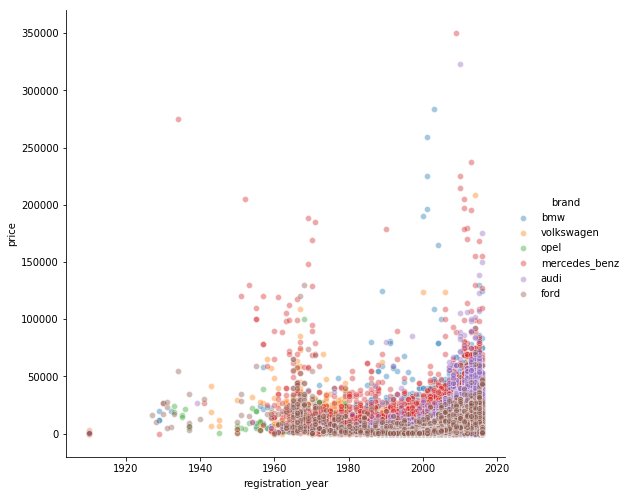

In [23]:
sns.pairplot(x_vars='registration_year',y_vars='price', data=top, hue="brand",height=7,plot_kws={'alpha':0.4})

In [24]:
top['brand'].value_counts(normalize=True)

volkswagen       0.306408
bmw              0.163600
opel             0.151482
mercedes_benz    0.145733
audi             0.133495
ford             0.099281
Name: brand, dtype: float64

The scatter plot reveals that the previous inference of a price cap at 350,000 may have been too high, as the assumption was such a high price could be due to the novelty of a vehicle, however we can see the data is skewed left and therefore reflects newer models. We can also see that volkswagen is by far the most popular choice making up 30% of the data. Now, we'll cap the price at 50,000, and furuther explore volkswagen. 

In [25]:
newtop = top[top['price']<50000]

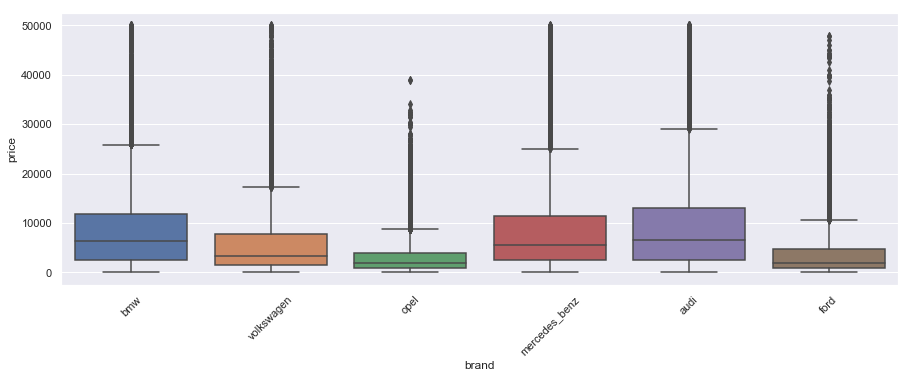

In [38]:
sns.set(rc={'figure.figsize':(15,5)})
ax=sns.boxplot(x='brand', y='price', data=newtop)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [27]:
def mean_price(brand):
    mean_year = {}
    for year in range(1910,2017):
        year_only = brand[brand['registration_year']== year]
        mean = year_only['price'].mean()
        mean_year[year] = mean
        
    clean_dict = {k: mean_year[k] for k in mean_year if not isnan(mean_year[k])}
    
    final = pd.Series(clean_dict)
    
    return final

In [28]:
volkswagen = newtop[newtop['brand']=='volkswagen']

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


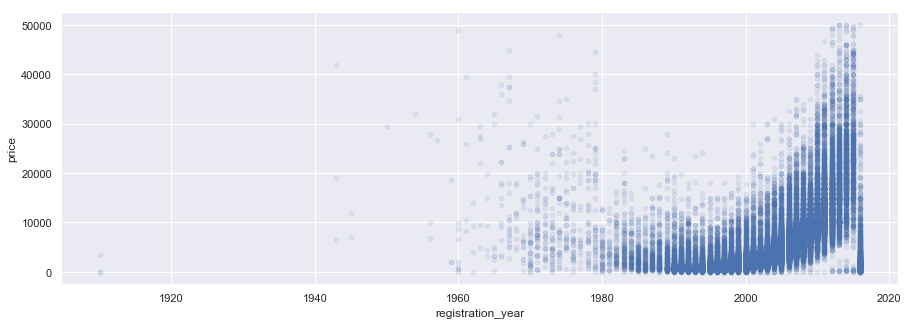

In [29]:
volkswagen.plot(kind='scatter',x='registration_year',y='price',alpha=0.1)

In [30]:
volkswagen.corr()

,price,registration_year
price,1.000000,0.543191
registration_year,0.543191,1.000000


As expected, there is a relatively strong correlation between price and registration year. The data starts to become more dense just after 1980, so let's explore those points.

In [31]:
volks_final = autos[autos['brand']=='volkswagen']
volks_final = volks_final[volks_final['price']<50000]
volks_final = volks_final[volks_final['registration_year']>1980]
volks_final.head()

,date_crawled,name,price,ab_test,vehicle_type,registration_year,gearbox,power_PS,model,odometer,registration_month,fuel_type,brand,unrepaired_damage,ad_created,postal_code,last_seen
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,1500,test,kleinwagen,2001,Manual,75,golf,150000,6,Gas,volkswagen,No,2016-03-17 00:00:00,91074,2016-03-17 17:40:17
11,2016-04-07 10:06:22,Volkswagen_Passat_Variant_2.0_TDI_Comfortline,2799,control,kombi,2005,Manual,140,passat,150000,12,diesel,volkswagen,Yes,2016-04-07 00:00:00,57290,2016-04-07 10:25:17
12,2016-03-15 22:49:09,"VW_Passat_Facelift_35i__""7Sitzer""",999,control,kombi,1995,Manual,115,passat,150000,11,Gas,volkswagen,NaN,2016-03-15 00:00:00,37269,2016-04-01 13:16:16
13,2016-03-21 21:37:40,VW_PASSAT_1.9_TDI_131_PS_LEDER,2500,control,kombi,2004,Manual,131,passat,150000,2,NaN,volkswagen,No,2016-03-21 00:00:00,90762,2016-03-23 02:50:54
20,2016-04-01 19:56:48,Volkswagen_Scirocco_1.4_TSI_Sport,10400,control,coupe,2009,Manual,160,scirocco,100000,4,Gas,volkswagen,No,2016-04-01 00:00:00,75365,2016-04-05 16:45:49


In [32]:
volks_final['model'].value_counts(normalize=True)

golf           0.390264
polo           0.168554
passat         0.138989
transporter    0.072756
touran         0.049589
lupo           0.034086
caddy          0.022104
sharan         0.021400
tiguan         0.013797
beetle         0.012123
bora           0.011732
touareg        0.010856
fox            0.010293
scirocco       0.008838
andere         0.008541
eos            0.007994
up             0.005287
jetta          0.004630
phaeton        0.003332
cc             0.002722
kaefer         0.001549
amarok         0.000563
Name: model, dtype: float64

So the golf is the most popular model by a margin of 22%. Now that we have the most popular model, let's look for some details as to why.

In [33]:
golf = volks_final[volks_final['model']=='golf']

In [34]:
golf.corr()

,price,registration_year,power_PS,odometer,registration_month,postal_code
price,1.000000,0.678420,0.328385,-0.708830,0.000840,0.028264
registration_year,0.678420,1.000000,0.192669,-0.485005,0.011204,-0.000710
power_PS,0.328385,0.192669,1.000000,-0.152890,0.012552,0.029647
odometer,-0.708830,-0.485005,-0.152890,1.000000,0.002656,0.002226
registration_month,0.000840,0.011204,0.012552,0.002656,1.000000,-0.008137
postal_code,0.028264,-0.000710,0.029647,0.002226,-0.008137,1.000000


From the data above, the strongest correlation visible is negative, and is between price and odometer. Let's take a closer look.

In [35]:
cols = ['price','odometer','registration_year']
golf = golf[cols]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


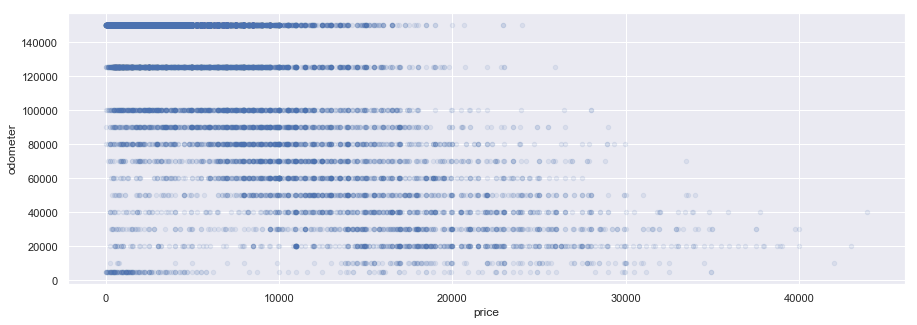

In [36]:
golf.plot(kind='scatter',x='price',y='odometer', alpha=0.1)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


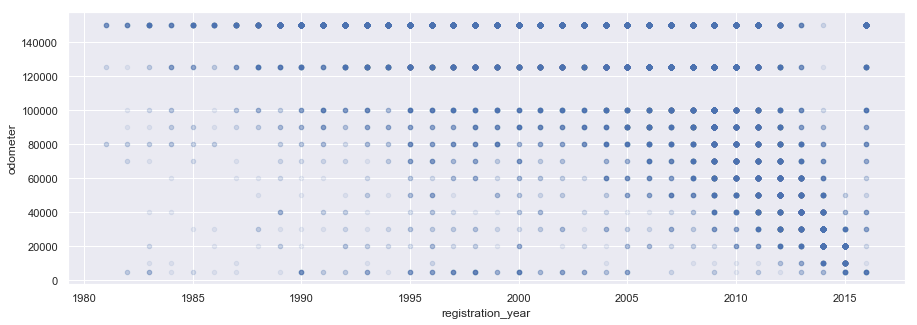

In [37]:
golf.plot(kind='scatter',x='registration_year',y='odometer',alpha=0.1)

We began by first examining our data, translating and removing information, exploring the numerical data, and finished by analyzing it further. It's clear now that the Volkswagen golf is the most popular brand and model. From the last visualiztion, we can see the majoirty of them have a high odometer count, specfically those beofre 2010. From the data availible we can infer that the sales reflect cars which have decreased in value due to use, rather than some other feature available in the data.